# Efficacy of Vocational Rehabilitation Services in America 

> Dataset: [Current Population Survey, July 2021: Disability Supplement](https://api.census.gov/data/2021/cps/disability/jul.html)
* The universe consists of all persons in the civilian non-institutional population of the United States living in households. 
* The probability sample selected to represent the universe consists of approximately 50,000 households.

### Imports

In [3]:
import requests
import pandas as pd
import numpy as np

### Data Dictionary
> Include information such as exact variable name in API, variable name in analysis, and variable name in visualization, description, measurement units, expected values, expected min/max


### Query Texas Records
> Querying individual records for **every** county in Texas

In [13]:
HOST = "https://api.census.gov/data"
year = "2019"
dataset = "cps/disability/jul"
base_url = "/".join([HOST, year, dataset])

predicates = {}
get_vars = ["PEMLR",
            "PESD1", 
            "PESD6A", 
            "PESD6B", 
            "PESD6C", 
            "PESD6D", 
            "PESD6E", 
            "PESD6F", 
            "PESD6G", 
            "PESD7A", 
            "PESD7B", 
            "PESD7C",
            "PESD7E", 
            "PESD7G", 
            "PRDISFLG", 
            "PESD41", 
            "PESD42", 
            "PESD43", 
            "PESD44", 
            "PESD45", 
            "PESD46", 
            "PESD47",
            "PESD48", 
            "PESD49",
            "PTDTRACE",
            "PESEX",
            "PRTAGE",
            "HEFAMINC"
            ]
predicates["get"] = ",".join(get_vars)
predicates["for"] = "county:*"
predicates["in"] = "state:48"

r = requests.get(base_url, params=predicates)

### Format Data Frame and turn to CSV

In [14]:
col_names = [
    "labor_force_employment_status",
    "how_disability_affects_ability_to_work",
    "used_vocational_rehabilitation_agencies",
    "used_one_stop_career_centers",
    "used_the_ticket_to_work_program",
    "used_assistive_technology_act_prog",
    "used_ctr_for_indpt_living_for_ind_w_dis",
    "used_the_client_assistance_program",
    "used_any_other_employment_assistance_program",
    "how_helpful_vocational_rehab_agency",
    "how_helpful_one_stop_career_centers",
    "the_ticket_to_work_program_helpfulness",
    "ctr_for_indpdt_living_for_ind_w_dis_helpful",
    "other_employment_assist_program_helpful",
    "does_this_person_have_any_of_these_disability_conditions",
    "barrier_lack_of_education_or_training",
    "barrier_lack_of_job_counseling",
    "barrier_lack_of_transportation",
    "barrier_loss_of_government_assistance",
    "barrier_need_for_special_features",
    "barrier_employer_or_coworker_attitudes",
    "barrier_your_difficulty_with_disability",
    "barrier_other",
    "barrier_none",
    "demographics_race_of_respondent",
    "demographics_sex",
    "demographics_age",
    "household_total_family_income_past_12_months",
    "state",
    "county"
]
df = pd.DataFrame(columns=col_names, data=r.json()[1:])
df.to_csv("raw-data.csv")

### Clean Data and Correct Output

In [9]:
data = pd.read_csv('raw-data.csv',header=0)
# drop all records that are not in the universe of labor_force_employment_status
filteredData = data[data["labor_force_employment_status"] != -1]
filteredData = filteredData.loc[:,  ~filteredData.columns.str.contains('^Unnamed')]

# categorize output variable into binary options
filteredData["labor_force_employment_status"] = filteredData["labor_force_employment_status"].apply(lambda x: 1 if x == 1 or x == 2 else 0)

filteredData.to_csv("cleaned-data.csv")

### Find significant variables
> Note: Solving a classification problem via inference

#### Options:
- Logistic Regression - commonly used for classification problems
- Stepwise
- Decision Trees
- Random forrest
- Neural Network

### Logistic Regression
* [Documentation](https://pytorch.org/tutorials/beginner/nn_tutorial.html#neural-net-from-scratch-no-torch-nn)
* Train minimal neural network (logsitic regression, since there are no hidden layers)

#### Step 1: Turn df to tensors

In [4]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

data = pd.read_csv('cleaned-data.csv',header=0)

# 80% training, 20% validation
x_var = data.loc[:, data.columns != "labor_force_employment_status"]
y_var = data.loc[:, data.columns == "labor_force_employment_status"]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

# Convert DataFrames to NumPy arrays and then to tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_valid = torch.tensor(x_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_valid = torch.tensor(y_valid.values, dtype=torch.float32)
n, c = x_train.shape

#### Step 2: Create model

In [13]:
import math

weights = torch.randn(c, 2) / math.sqrt(c)
weights.requires_grad_()

bias = torch.zeros(2, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

y_train = y_train.squeeze().long()  # Ensure it's 1D and long type for classification
yb = y_train[0:bs]

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.4531)
tensor(nan, grad_fn=<NegBackward0>) tensor(0.2759)


### Decision Tree
> re-use training and test datasets

[https://www.datacamp.com/tutorial/decision-tree-classification-python](Resource)

[https://scikit-learn.org/stable/modules/tree.html](Docs)

[https://www.youtube.com/watch?v=q90UDEgYqeI](Video)

#### Preliminary Tree
* no pruning done with default hyperparameters

[Text(0.5836993790340924, 0.984375, 'demographics_age <= 66.5\ngini = 0.488\nsamples = 3933\nvalue = [1659, 2274]\nclass = Employed'),
 Text(0.2082043622713373, 0.953125, 'barrier_lack_of_transportation <= 0.0\ngini = 0.446\nsamples = 3259\nvalue = [1094, 2165]\nclass = Employed'),
 Text(0.2068033114832462, 0.921875, 'demographics_age <= 18.5\ngini = 0.423\nsamples = 3109\nvalue = [944, 2165]\nclass = Employed'),
 Text(0.04934325744308231, 0.890625, 'demographics_age <= 17.5\ngini = 0.318\nsamples = 267\nvalue = [214, 53]\nclass = Unemployed'),
 Text(0.03371278458844133, 0.859375, 'Unnamed: 0 <= 3096.5\ngini = 0.234\nsamples = 200\nvalue = [173, 27]\nclass = Unemployed'),
 Text(0.022942206654991245, 0.828125, 'county <= 98.0\ngini = 0.342\nsamples = 105\nvalue = [82, 23]\nclass = Unemployed'),
 Text(0.01576182136602452, 0.796875, 'Unnamed: 0 <= 1912.5\ngini = 0.283\nsamples = 88\nvalue = [73.0, 15.0]\nclass = Unemployed'),
 Text(0.00840630472854641, 0.765625, 'demographics_race_of_resp

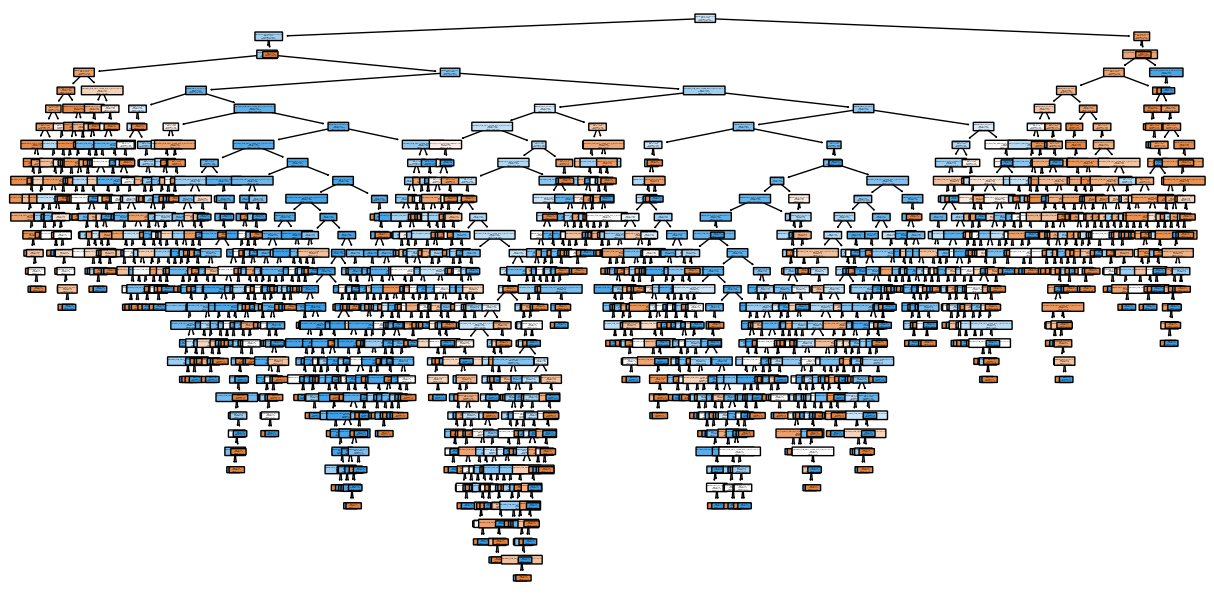

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    x_var,
    y_var,
    test_size=0.2,
    random_state=42
)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf,
          filled=True,
          rounded=True,
          class_names=["Unemployed", "Employed"],
          feature_names=x_var.columns,
        )
 

              precision    recall  f1-score   support

           0       0.60      0.62      0.61       415
           1       0.72      0.70      0.71       569

    accuracy                           0.67       984
   macro avg       0.66      0.66      0.66       984
weighted avg       0.67      0.67      0.67       984



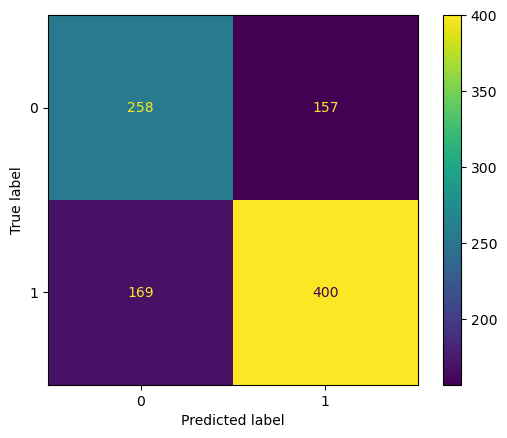

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(classification_report(y_test, y_pred))